### 0. Imports

In [68]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_outliers as so
import src.ab_testing_support as ats
import src.association_metrics as am
import src.data_preparation as dp
import src.model_evaluation_support as mes
import src.soporte_ajuste_logistica_miercoles as salm

# Machine Learning tools
# -----------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import  RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV

import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

from xgboost import XGBClassifier



# encoding
# -----------------------------------------------------------------------
from sklearn.preprocessing import  OneHotEncoder
import category_encoders as ce
# set category encoder compatibility
import sklearn
sklearn.set_config(transform_output="pandas")

# scaling
# -----------------------------------------------------------------------
from sklearn.preprocessing import  RobustScaler, StandardScaler


# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr

# model tracking
# -----------------------------------------------------------------------
import mlflow

# definir semilla random
# -----------------------------------------------------------------------
seed = 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Introduction - Employee Retention - Model Evaluation

## 1.1 Data import

In [69]:
employee_attrition = pd.read_pickle("../data/explored/employee_attrition_explored.pkl")

## 2. Set experiment tracking with MLflow

Set MLFlow tracking folder, activate autolog and set an experiment name for tracking.

In [70]:
# mlflow.set_tracking_uri("../model_tracking")  # Local directory
# mlflow.set_experiment("employee_retention")
# mlflow.autolog()

# 3. Model evaluation

## 3.1 Experiment 1 - baseline

### 3.1.1 Data preparation

Data preparation for load, cleaning and correction of errors found throughout the 1_exploration_cleaning, 2_EDA and 3_preprocessing notebooks have been integrated into a load and clean function, available at ``src/data_preparation.py``.

In [71]:
list_of_paths = ["../data/general_data.csv","../data/employee_survey_data.csv","../data/manager_survey_data.csv"]

employee_attrition = dp.load_and_clean(list_of_paths, "EmployeeID")
employee_attrition.sample(5)

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,gender,joblevel,jobrole,...,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating
80,30,0,Travel_Rarely,Research & Development,10,3,Life Sciences,Male,2,Research Scientist,...,10.0,2,10.0,1,2,4.0,3.0,3.0,2,3
955,23,1,Travel_Rarely,Research & Development,12,2,Medical,Male,2,Research Scientist,...,3.0,2,3.0,0,2,3.0,4.0,3.0,3,3
781,34,1,Travel_Rarely,Research & Development,7,4,Medical,Male,2,Research Scientist,...,2.0,3,2.0,2,2,1.0,3.0,3.0,3,3
1464,29,0,Travel_Rarely,Sales,4,3,Other,Female,2,Human Resources,...,6.0,2,6.0,1,5,3.0,4.0,3.0,2,3
999,31,1,Travel_Rarely,Human Resources,9,4,Other,Male,2,Laboratory Technician,...,10.0,2,1.0,0,0,1.0,3.0,3.0,3,3


### 3.1.2 Define target and predictors

In [72]:
y = employee_attrition["attrition"]
X = employee_attrition.drop(columns="attrition")

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

### 3.1.3 Data preprocessing

- Missing: Median imputation for numerical features. Mode for categorical.
- Outliers: False.
- Encoding: One hot encoder for <= 3 categories. Target for others.
- Scaling: False. (Only tree based models will be used)

Setting the conditions for data preprocessing:

In [73]:
categorical = X.select_dtypes("object").columns.to_list()

# current numpy version doesn't work well with np.number for this:
numerical = X.select_dtypes(["int64","float64"]).columns.to_list()

all_columns = X.columns.to_list()

columns_one_hot = [col for col in categorical if X[col].nunique() <= 3]
columns_target =[col for col in categorical if X[col].nunique() > 3]


imputer = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

# Combine into a pipeline to later append the model
preprocessing_pipeline = Pipeline([
    ('imputer', imputer),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.TargetEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

Checking the preprocessing pipeline:

In [74]:
preprocessing_pipeline.fit_transform(X,y).sample(7)

,age,distancefromhome,monthlyincome,totalworkingyears,yearsatcompany,businesstravel_Travel_Rarely,businesstravel_Travel_Frequently,businesstravel_Non-Travel,department_Sales,department_Research & Development,...,percentsalaryhike,trainingtimeslastyear,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating_3.0,performancerating_4.0
1024,33.0,8.0,82240.0,14.0,10.0,1,0,0,0,1,...,0.187433,0.172414,0.19994,0.157165,0.133333,0.229236,0.139202,0.154341,1,0
979,32.0,26.0,88230.0,10.0,0.0,1,0,0,0,1,...,0.172727,0.172414,0.192,0.313793,0.247492,0.165541,0.139202,0.154341,1,0
1665,26.0,2.0,59930.0,8.0,7.0,0,1,0,0,1,...,0.154206,0.172414,0.137931,0.313793,0.148026,0.166667,0.170868,0.154341,1,0
972,24.0,3.0,14160.0,6.0,6.0,1,0,0,0,1,...,0.2056,0.172414,0.137931,0.145604,0.148026,0.229236,0.179487,0.156962,1,0
1101,34.0,8.0,25850.0,9.0,4.0,1,0,0,0,1,...,0.154206,0.131783,0.192,0.14637,0.133333,0.110236,0.170868,0.154341,1,0
426,40.0,1.0,192320.0,11.0,1.0,1,0,0,0,1,...,0.136364,0.172414,0.192,0.313793,0.247492,0.165541,0.170868,0.154341,1,0
1187,41.0,13.0,109200.0,21.0,20.0,1,0,0,0,1,...,0.2056,0.172414,0.192,0.057715,0.247492,0.165541,0.139202,0.174194,1,0


### 3.1.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [169]:
models = {
    'decision_tree': (
        DecisionTreeClassifier(random_state=seed),
        {
            'classifier__max_depth': [None, 5, 10, 15],
            'classifier__min_samples_split': [5, 10, 15],
            'classifier__min_samples_leaf': [2, 5, 10],
            'classifier__max_leaf_nodes': [20, 30, None],
            'classifier__max_features': ['sqrt', 'log2']
        }
    ),

    'random_forest': (
        RandomForestClassifier(random_state=seed, n_jobs=-1),
        {
            'classifier__n_estimators': [50, 100, 150, 200],
            'classifier__max_depth': [10, 15, 20, 25],
            'classifier__min_samples_split': [2, 5, 10, 15],
            'classifier__min_samples_leaf': [1, 5, 10],
            'classifier__bootstrap': [True, False]
        }
    ),

    'xgboost': (
        XGBClassifier(n_jobs=-1, random_state=seed),
        {
            'classifier__n_estimators': [50, 75],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3,5],
            'classifier__min_child_weight': [1, 2],
            'classifier__colsample_bytree': [0.8,0.9],
            'classifier__gamma': [0.05, 1, 1.5],
            'classifier__reg_alpha': [0.05, 0.1],
            'classifier__reg_lambda': [1],
        }
    )

# {'classifier__colsample_bytree': 0.85,
#  'classifier__gamma': 1.5,
#  'classifier__learning_rate': 0.05,
#  'classifier__max_depth': 3,
#  'classifier__min_child_weight': 3,
#  'classifier__n_estimators': 75,
#  'classifier__reg_alpha': 0.05,
#  'classifier__reg_lambda': 1}

}


### 3.1.5 Run experiment

Perform train and test split. Define a stratified kfold cross validation to improve metric robustness in face of target imbalance. Optimize for minimal average_precision_score, which is the equivalent of the area under the Precision-Recall curve, which is more informative than AUC for imbalanced datasets.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
score = "average_precision"

verbosity = 2

Evaluate Decision Tree:

In [171]:
analista_clasificacion = salm.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration1")

analista_clasificacion.ajustar_modelo("decision_tree", preprocessing_pipeline=preprocessing_pipeline, param_grid=models["decision_tree"][1], cross_validation=cross_val)

analista_clasificacion.calcular_metricas("decision_tree")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.860095,0.839528,0.860095,0.834299,0.316946,0.770798,0.459357,0.341449,0.073851,12.0
test,0.841270,0.808657,0.841270,0.814388,0.230957,0.572189,0.255678,0.341449,0.073851,12.0


Evaluate Random Forest:

In [172]:
analista_clasificacion.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline, param_grid=models["random_forest"][1], cross_validation=cross_val)

analista_clasificacion.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.938792,0.942952,0.938792,0.932662,0.731573,0.999119,0.995768,1.013744,0.195334,12.0
test,0.857143,0.846509,0.857143,0.812635,0.198473,0.765283,0.511263,1.013744,0.195334,12.0


Evaluate Xgboost:

In [173]:
analista_clasificacion.ajustar_modelo("xgboost", preprocessing_pipeline=preprocessing_pipeline, param_grid=models["xgboost"][1], cross_validation=cross_val)

analista_clasificacion.calcular_metricas("xgboost")

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.872019,0.875765,0.872019,0.838097,0.319589,0.883645,0.701172,0.361094,0.077316,12.0
test,0.857143,0.846509,0.857143,0.812635,0.198473,0.711170,0.406924,0.361094,0.077316,12.0


In [176]:
for model in models.keys():
    print(f"{model} - best params:")
    display(analista_clasificacion.resultados[model]["best_params"])

decision_tree - best params:


{'classifier__max_depth': 5,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 5}

random_forest - best params:


{'classifier__bootstrap': True,
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 200}

xgboost - best params:


{'classifier__colsample_bytree': 0.9,
 'classifier__gamma': 1.5,
 'classifier__learning_rate': 0.05,
 'classifier__max_depth': 3,
 'classifier__min_child_weight': 2,
 'classifier__n_estimators': 75,
 'classifier__reg_alpha': 0.05,
 'classifier__reg_lambda': 1}

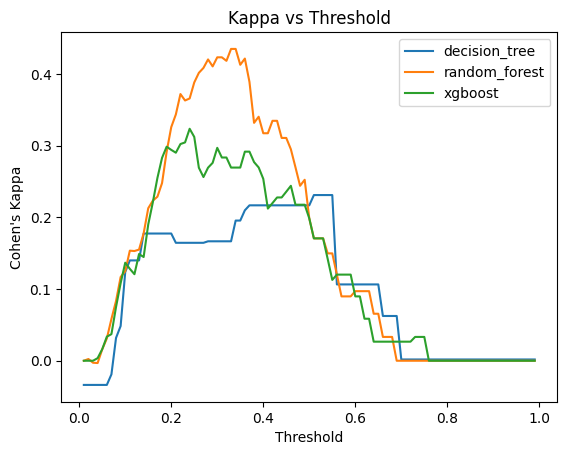

In [178]:
analista_clasificacion.plot_cohens_kappa(models.keys())

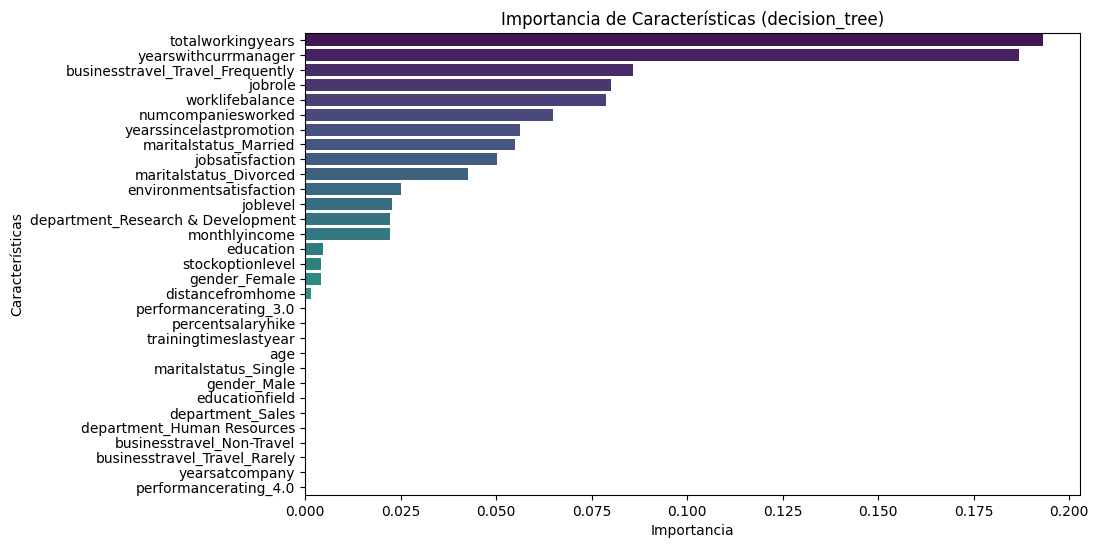

In [199]:
analista_clasificacion.importancia_predictores("decision_tree", pipeline=True)

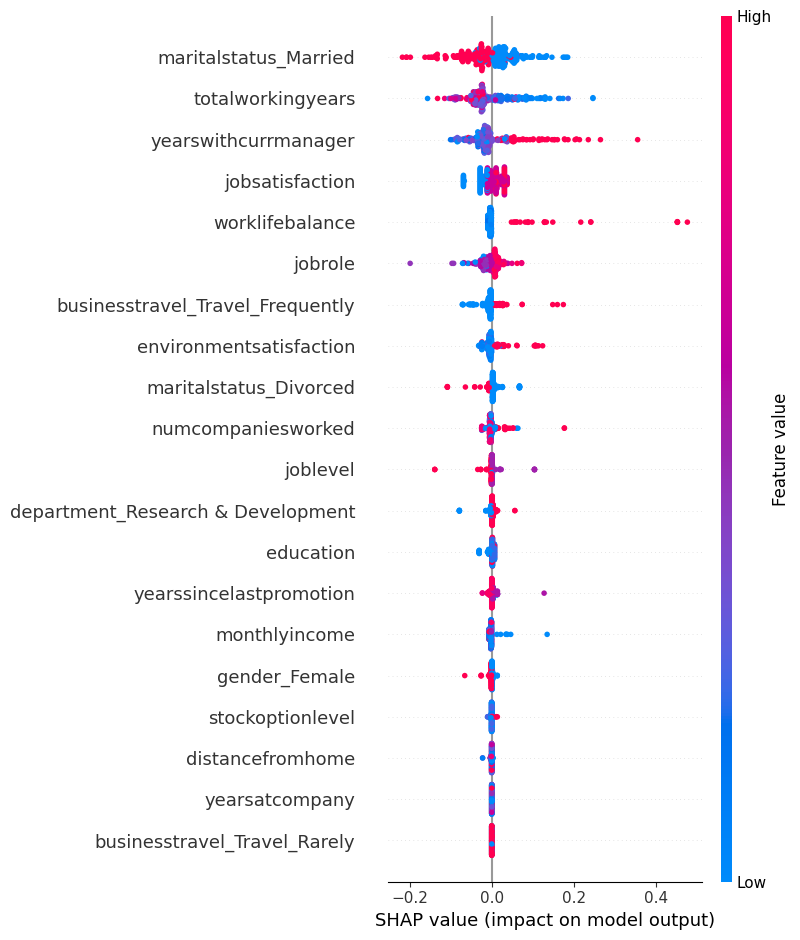

In [204]:
analista_clasificacion.plot_shap_summary("decision_tree", pipeline=True)

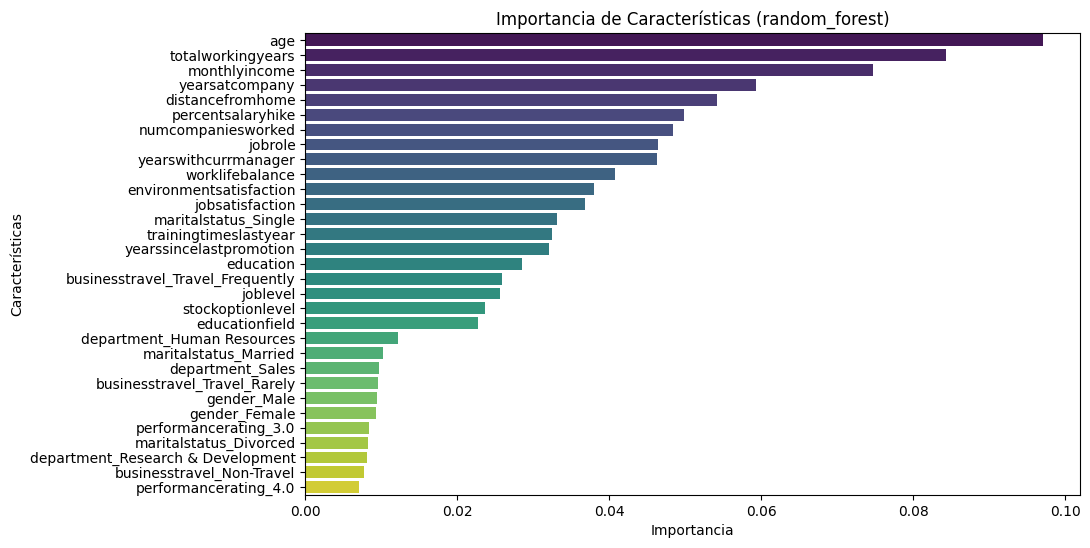

In [200]:
analista_clasificacion.importancia_predictores("random_forest", pipeline=True)

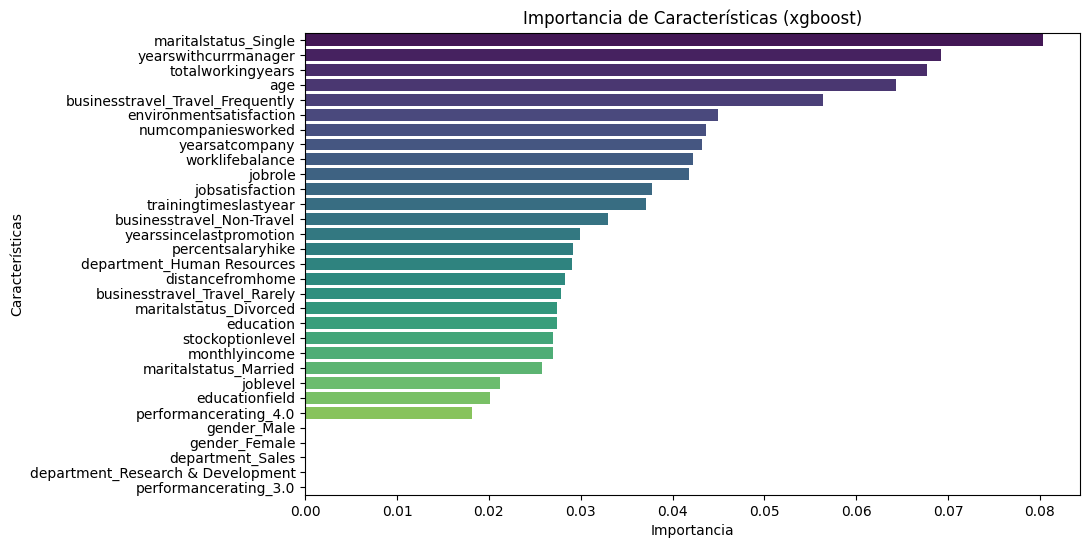

In [205]:
analista_clasificacion.importancia_predictores("xgboost", pipeline=True)

## 3.2 Experiment 2

Same, only changing the TargetEncoder for a CatBoost encoder.

In [ ]:
models["catboost"] = {
    
}

In [206]:
preprocessing_pipeline = Pipeline([
    ('imputer', imputer),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.TargetEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

In [207]:
analista_clasificacion.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline, param_grid=models["catboost"][1], cross_validation=cross_val)

analista_clasificacion.calcular_metricas("catboost")

KeyError: 'catboost'